In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from model import Model
from torchvision.datasets import Cityscapes
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import wandb
import numpy as np

from sklearn.metrics import \
    confusion_matrix, \
    precision_score, \
    recall_score, \
    f1_score, \
    roc_curve, \
    RocCurveDisplay, \
    roc_auc_score

In [2]:
# Transform image scale, Tensor and normalize
transform = transforms.Compose([transforms.Resize((1024//16, 2048//16)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transforms = transforms.Compose([transforms.Resize((1024//16, 2048//16),transforms.InterpolationMode.NEAREST), transforms.ToTensor()])

# data loading for local
dataset = Cityscapes(root='./data', split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transforms)

# data loading for snellius
#dataset = Cityscapes(args.data_path, split='train', mode='fine', target_type='semantic', transform=transform, target_transform=target_transforms)

torch.manual_seed(1)
# split dataset in train and val
train_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)


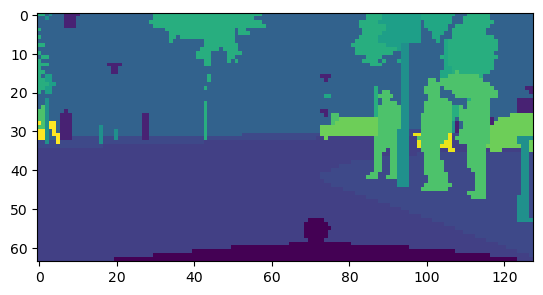

In [3]:
# plot image
img,label = train_loader.dataset[1]
plt.imshow(label[0,:,:])
plt.show()

In [4]:
# define model
model = Model()

# define optimizer and loss function (don't forget to ignore class index 255)
learning_rate = 0.01
num_epochs = 30
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="segmentation_project",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "CNN",
    "dataset": "Cityscapes",
    "epochs": num_epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lucmanders (team-321). Use `wandb login --relogin` to force relogin


In [5]:
# training/validation loop
for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_pres_train = 0
    epoch_iou_train = 0
    for inputs, masks in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        masks = (masks * 255)
        masks = masks.squeeze(1)
        loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    
    epoch_loss_train = train_loss / len(train_loader)
    # epoch_pres_train = precision_score / len(train_loader)
    # epoch_iou_train = iou_score / len(train_loader)

    # val_loss = 0.0
    # model.eval()
    # with torch.inference_mode():
    #     for inputs, masks in val_loader:
    #         val_outputs = model(inputs)
    #         masks = (masks * 255)
    #         val_loss = criterion(val_outputs, masks.long().squeeze())
    #         val_loss += val_loss.item()
    #     epoch_loss_val = val_loss / len(val_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss train: {epoch_loss_train:.8f}')
    wandb.log({"loss": epoch_loss_train})


# save model
torch.save(model,'./models/first_model.pth')

Epoch 1/30, Loss train: 1.56909349
Epoch 2/30, Loss train: 1.09616772
Epoch 3/30, Loss train: 1.01657834
Epoch 4/30, Loss train: 0.95450603
Epoch 5/30, Loss train: 0.91718732


KeyboardInterrupt: 

tensor([[-4.3316, -4.0866, -4.1309,  ..., -5.8734, -5.5449, -5.7458],
        [-3.6297, -4.4994, -5.1564,  ..., -6.3219, -5.6782, -5.9244],
        [-3.7884, -5.1736, -5.9865,  ..., -6.5380, -5.9815, -6.1174],
        ...,
        [-1.6993,  0.1792,  0.7821,  ...,  0.2519, -0.7202, -2.4762],
        [-0.9474,  1.3259,  2.1855,  ...,  1.2558,  0.5596, -1.3221],
        [ 0.1578,  2.9423,  3.5943,  ...,  2.8857,  2.3802,  0.0479]])


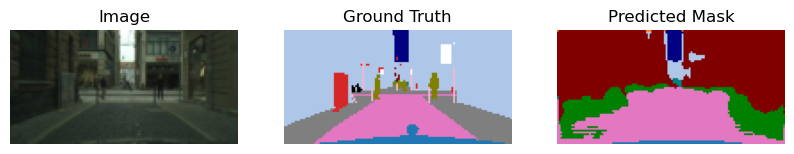

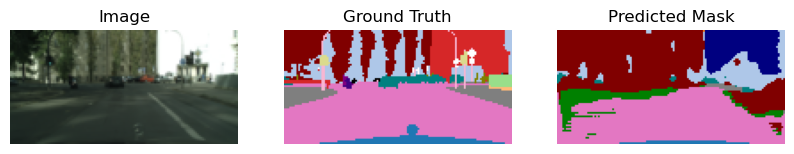

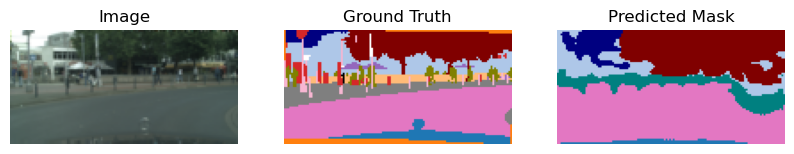

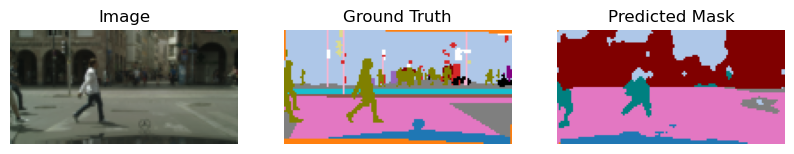

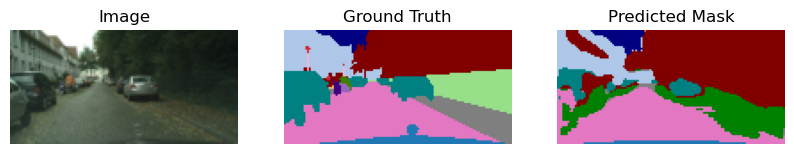

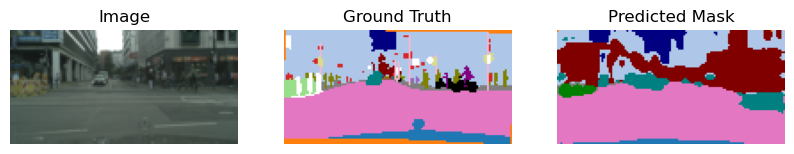

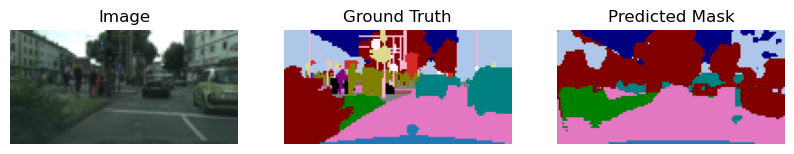

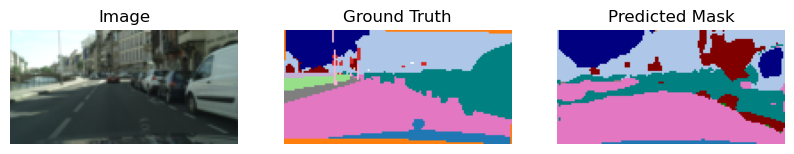

In [13]:
def mask_to_rgb(mask, class_to_color):
    """
    Converts a numpy mask with multiple classes indicated by integers to a color RGB mask.

    Parameters:
        mask (numpy.ndarray): The input mask where each integer represents a class.
        class_to_color (dict): A dictionary mapping class integers to RGB color tuples.

    Returns:
        numpy.ndarray: RGB mask where each pixel is represented as an RGB tuple.
    """
    # Get dimensions of the input mask
    height, width = mask.shape

    # Initialize an empty RGB mask
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Iterate over each class and assign corresponding RGB color
    for class_idx, color in class_to_color.items():
        # Mask pixels belonging to the current class
        class_pixels = mask == class_idx
        # Assign RGB color to the corresponding pixels
        rgb_mask[class_pixels] = color

    return rgb_mask

def visualize_segmentation(model, dataloader, num_examples=5):
    """
    Visualizes segmentation results from a given model using a dataloader.

    Args:
        model (torch.nn.Module): The segmentation model to visualize.
        dataloader (torch.utils.data.DataLoader): Dataloader providing image-mask pairs.
        num_examples (int, optional): Number of examples to visualize. Defaults to 5.

    Returns:
        None
    """
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_examples:
                break
            
            outputs = model(images)
            outputs = torch.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, 1)

            images = images.numpy()
            masks = masks.numpy()*255

            predicted = predicted.numpy()

            for j in range(images.shape[0]):
                image = renormalize_image(images[j].transpose(1, 2, 0))

                mask = masks[j].squeeze()
                pred_mask = predicted[j]
                                
                # Convert mask and predicted mask to RGB for visualization
                mask_rgb = mask_to_rgb(mask, colors)
                pred_mask_rgb = mask_to_rgb(pred_mask, colors)
                
                # Get unique classes present in the ground truth and predicted masks
                unique_classes_gt = np.unique(mask)
                unique_classes_pred = np.unique(pred_mask)
                
                unique_classes_gt = np.delete(unique_classes_gt, [0, -1])
                unique_classes_pred= np.delete(unique_classes_pred, 0)
                
                unique_classes_gt[unique_classes_gt == 255] = 0
                unique_classes_pred[unique_classes_pred == 255] = 0
                
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 3, 1)
                plt.imshow(image)
                plt.title('Image')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask_rgb)
                plt.title(f'Ground Truth')
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask_rgb)
                plt.title(f'Predicted Mask')
                plt.axis('off')

                plt.show()
def renormalize_image(image):
    """
    Renormalizes the image to its original range.
    
    Args:
        image (numpy.ndarray): Image tensor to renormalize.
    
    Returns:
        numpy.ndarray: Renormalized image tensor.
    """
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]  
    renormalized_image = image * std + mean
    return renormalized_image

colors = {
        0: (0, 0, 0),
        1: (31, 119, 180),
        2: (255, 127, 14),  
        3: (44, 160, 44),   
        4: (214, 39, 40), 
        5: (148, 103, 189),
        6: (140, 86, 75),
        7: (227, 119, 194),
        8: (127, 127, 127),
        9: (188, 189, 34),
        10: (23, 190, 207),
        11: (174, 199, 232),
        12: (255, 187, 120),
        13: (152, 223, 138),
        14: (255, 152, 150),
        15: (197, 176, 213),
        16: (196, 156, 148),
        17: (247, 182, 210),
        18: (199, 199, 199),
        19: (219, 219, 141),
        20: (255, 255, 255),
        21: (128, 0, 0),     
        22: (0, 128, 0),      
        23: (0, 0, 128),      
        24: (128, 128, 0),   
        25: (128, 0, 128),    
        26: (0, 128, 128),   
        27: (64, 64, 64),     
        28: (64, 0, 0),     
        29: (192, 192, 192),  
        30: (64, 128, 0),    
        31: (100, 64, 32),   
        32: (64, 0, 128),  
        33: (0, 0, 0)
}

class_names = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
    'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor','sky','pole','traffic sign',
    'traffic light','pole group','person','rider','static','ground','dynamic','test1','test2','test3'
]
# Think about results
# torch.manual_seed(1)
visualize_segmentation(model, val_loader, num_examples=1)